In [1]:
import scipy  # type: ignore
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [3]:
# Define paths
# Update the base directory to the correct path
base_dir = r'C:\Users\fab\Documents\projects\smart-banana\BananaLSD\AugmentedSet'
diseases = ['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']

# show the number of images in each class
for disease in diseases:
    path = os.path.join(base_dir, disease)
    num_images = len(os.listdir(path))
    print(f"{disease}: {num_images} images")
    
    

cordana: 400 images
healthy: 400 images
pestalotiopsis: 400 images
sigatoka: 400 images


In [4]:
# Image parameters
img_height = 224
img_width = 224
batch_size = 32

In [5]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)


In [6]:
# Load and prepare training data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


Found 1280 images belonging to 4 classes.


In [7]:
# Load and prepare validation data
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 320 images belonging to 4 classes.


In [8]:
# Build the CNN model
model = models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(diseases), activation='softmax')
])

In [9]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=0.00001
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    restore_best_weights=True
)

In [11]:
import tensorflow as tf
print(tf.__version__)


2.13.0


In [12]:
# Ensure scipy is available

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

10/10 [==============================] - 6s 625ms/step - loss: 1.3926 - accuracy: 0.2281
Test accuracy: 22.81%


Epoch 1/20
40/40 [==============================] - 84s 2s/step - loss: 1.2774 - accuracy: 0.3891 - val_loss: 1.1206 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/20
40/40 [==============================] - 59s 1s/step - loss: 1.1001 - accuracy: 0.5383 - val_loss: 0.9950 - val_accuracy: 0.5594 - lr: 1.0000e-04
Epoch 3/20
40/40 [==============================] - 53s 1s/step - loss: 1.0411 - accuracy: 0.5742 - val_loss: 0.9130 - val_accuracy: 0.6938 - lr: 1.0000e-04
Epoch 4/20
40/40 [==============================] - 59s 1s/step - loss: 0.9247 - accuracy: 0.6391 - val_loss: 0.7976 - val_accuracy: 0.7125 - lr: 1.0000e-04
Epoch 5/20
40/40 [==============================] - 75s 2s/step - loss: 0.8407 - accuracy: 0.6820 - val_loss: 0.7540 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 6/20
40/40 [==============================] - 59s 1s/step - loss: 0.7866 - accuracy: 0.6992 - val_loss: 0.7131 - val_accuracy: 0.7469 - lr: 1.0000e-04
Epoch 7/20
40/40 [==============================] - 99s 3s

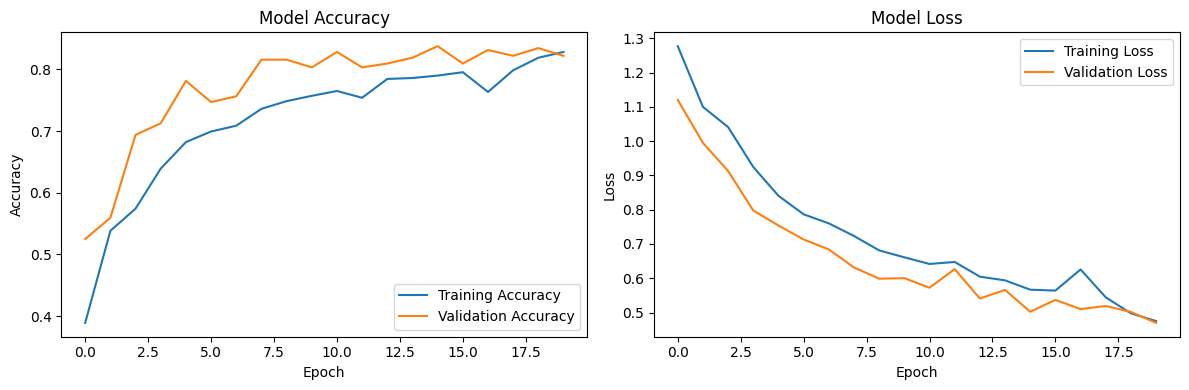

In [13]:
# Train the model and store the training history
history = model.fit(
	train_generator,
	validation_data=validation_generator,
	epochs=20,  # You can adjust the number of epochs as needed
	callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# Save the model
model.save('banana_disease_classification_model.keras')
model.save_weights('banana_disease_classification_weights.h5')
# Save the model architecture
model_json = model.to_json()
with open('banana_disease_classification_model.json', 'w') as json_file:
    json_file.write(model_json)
# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
# Save the class indices
class_indices = train_generator.class_indices
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
# Save the model weights
model.save_weights('banana_disease_classification_weights.h5')
print("Model saved successfully!")


Model saved successfully!
